# 0.0 IMPORTS 

In [173]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
import inflection
import pickle
import xgboost as xgb

from tabulate                import tabulate
from collections             import Counter

from IPython.core.display    import HTML
from IPython.core.display    import Image

from scipy.stats             import chi2_contingency

from imblearn.over_sampling  import SMOTE
from imblearn.over_sampling  import RandomOverSampler

from boruta                  import BorutaPy

from lightgbm                import LGBMClassifier

from sklearn.neighbors       import KNeighborsClassifier
from sklearn.impute          import SimpleImputer
from sklearn.tree            import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder

from sklearn.metrics         import precision_score
from sklearn.metrics         import recall_score
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import f1_score
from sklearn.metrics         import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics         import roc_auc_score, roc_curve
from scikitplot              import metrics      as mt
from sklearn.metrics         import accuracy_score, classification_report,cohen_kappa_score,recall_score,f1_score,roc_auc_score, plot_precision_recall_curve, precision_score,roc_curve

from imblearn.over_sampling import RandomOverSampler
from imblearn               import over_sampling, under_sampling
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [ ]:
def cross_validation( model_name, model, cv=5):
    
    # model
    scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
    cv=5
    m_result_cv = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
    
    # perfomance
    accuracy =  np.round ( np.mean( m_result_cv['test_accuracy']), 4).astype(str)  + ' +- ' + ( np.round (np.std( m_result_cv['test_accuracy']), 4).astype(str)) 
    precision = np.round ( np.mean( m_result_cv['test_precision']), 4).astype(str)  + ' +- ' + ( np.round (np.std( m_result_cv['test_precision']), 4).astype(str)) 
    f1 = np.round ( np.mean( m_result_cv['test_f1']), 4).astype(str)  + ' +- ' + ( np.round (np.std( m_result_cv['test_f1']), 4).astype(str)) 
    recall = np.round ( np.mean( m_result_cv['test_recall']), 4).astype(str)  + ' +- ' + ( np.round (np.std( m_result_cv['test_recall']), 4).astype(str)) 
    aucroc = np.round ( np.mean( m_result_cv['test_roc_auc']), 4).astype(str)  + ' +- ' + ( np.round (np.std( m_result_cv['test_roc_auc']), 4).astype(str)) 
    
    # result
    return pd.DataFrame({'Model Name': model_name,
                         'Accuracy': accuracy,
                         'Precision': precision,
                         'F1-Measure': f1,
                         'Recall': recall,
                         'AUC-ROC': aucroc}, index=[0])

def fraud_loss_saved ( df , model_name, model, yhat_model ):
    df['predictions'] = yhat_model
    total_fraud_amt = df[df['is_fraud'] == 1]['transaction_amt'].sum()
    total_fraud_amt_detected = df.loc[(df['predictions'] ==1 ) & ( df['is_fraud']== 1) ]['transaction_amt'].sum()
    detection_rate  = 100 * ( df[df['predictions'] ==1 ]['is_fraud'].sum()) / df['is_fraud'].sum()
    auc_score = roc_auc_score( df['is_fraud'], df['predictions'] )
    f1 = f1_score( df['is_fraud'], df['predictions'] )
    
    return pd.DataFrame({'Model Name': model_name,
                         'Total Fraud Amount': total_fraud_amt,
                         'Total Fraud Amount Detected': total_fraud_amt_detected,
                         'Fraud Loss Saved (%)': str( round( 100 * total_fraud_amt_detected / total_fraud_amt , 2 ) ),
                         'Detection Rate (%)': detection_rate,
                         'AUROC Score': auc_score,
                         'F1 Score': f1}, index=[0])

def ml_error( model_name, y_test, yhat ):
    accuracy = accuracy_score( y_test, yhat )
    precision = precision_score( y_test, yhat)
    f1_scr = f1_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    
    return pd.DataFrame( { 'Model Name':   model_name,
                           'Accuracy':     accuracy,
                           'Precision':    precision,
                           'F1 Score':     f1_scr,
                           'Recall Score': recall}, index=[0])


def cramers_V(var1,var2) :
      crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
      stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
      obs = np.sum(crosstab) # Number of observations
      mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
      return (stat/(obs*mini))

def jupyter_settings(): 
    %matplotlib inline 
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [24, 20]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') ) 
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 1000
    pd.set_option( 'display.expand_frame_repr', False ) 
    sns.set()

In [ ]:
jupyter_settings()

## 0.2 Loading Data

In [ ]:
# loading train dataset
df_identity_raw = pd.read_csv('data/train_identity.csv', nrows = 100000, low_memory=False)
df_transaction_raw = pd.read_csv('data/train_transaction.csv', nrows = 100000, low_memory=False)

#merge
df_raw = pd.merge(df_identity_raw, df_transaction_raw, on='TransactionID', how='inner')

# 1.0 DESCRIÇÃO DOS DADOS

In [ ]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [ ]:
## 1. Rename Columns
cols_old = df1.columns.values

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map (snakecase, cols_old))

#rename
df1.columns = cols_new 

## 1.2 Data Dimensions

In [ ]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

## 1.3 Data Types

In [ ]:
df1.dtypes

## 1.4 Check NA

In [ ]:
df1.isna().sum()

## 1.5 Drop out NA Columns 

In [ ]:
# drop columns with > 90% missing values ratio 
df1 = df1.dropna(axis=1, thresh=int(0.9*len(df1)))

## 1.5.2 Fill Out NA 

In [ ]:
cols_cat = df1.select_dtypes(include='object').columns.values
cols_num = df1.select_dtypes(include=['int64', 'float64']).columns.values

# fill with mean for numerical attributes
df1[cols_num] = df1[cols_num].fillna(df1[cols_num].mean())

# fill with mode for categorical attributes
df1[cols_cat] = df1[cols_cat].fillna(df1[cols_cat].mode().iloc[0])

## 1.6 Change Types

In [ ]:
# Listing dates between '2017-10-01' and '2019-01-01 
dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df1['transaction_dt'] = df1['transaction_dt'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

## 1.7 Descriptive Statistical

In [ ]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [ ]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

### 1.7.2 Categorical Attributes

In [ ]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

## 2.0 FEATURE ENGINEERING

In [ ]:
df2 = df1.copy()

## Mapa Mental de Hipoteses

In [ ]:
Image('imgs/Transaes_Fraudulentas.png')

## 2.2 Lista de Hipoteses

**H1.** Deveriam ocorrer mais fraudes em transações de produtos do tipo C

**H2.** Deveriam ocorrer mais fraudes em transações de produtos com valor abaixo de R$ 100.

**H3.** Deveriam ocorrer mais fraudes em transações de produtos com valor a cima de R$ 500.

**H4.** Deveriam ocorrer mais fraudes em transações realizadas no periodo noturno.

**H5.** Deveriam ocorrer mais fraudes em transações realizadas durante a semana.

**H6.** Deveriam ocorrer mais fraudes em transações realizadas durante o final de semana.

**H7.** Deveriam ocorrer mais fraudes em transações realizadas em cartão com bandeira Visa.

**H8.** Deveriam ocorrer mais fraudes em transações realizadas em cartão com bandeira Mastercard.

**H9.** Deveriam ocorrer mais fraudes em transações realizadas em cartão de crédito.

## 2.3 Feature Engineering

In [ ]:
# day_of_week
df2['day_of_week'] = df2['transaction_dt'].dt.dayofweek

# hour
df2['hour'] = df2['transaction_dt'].dt.hour

# day
df2['day'] = df2['transaction_dt'].dt.day

#month
df2['month'] = df2['transaction_dt'].dt.month

# 3.0 FILTRAGEM DAS VARIÁVEIS

In [ ]:
df3 = df2.copy()

# 4.0 ANALISE EXPLORATÓRIA DOS DADOS

In [ ]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.2 Response  Variable

In [431]:
df4['is_fraud'].value_counts(normalize= True) * 100

0    96.590745
1     3.409255
Name: is_fraud, dtype: float64

<AxesSubplot:xlabel='is_fraud', ylabel='Density'>

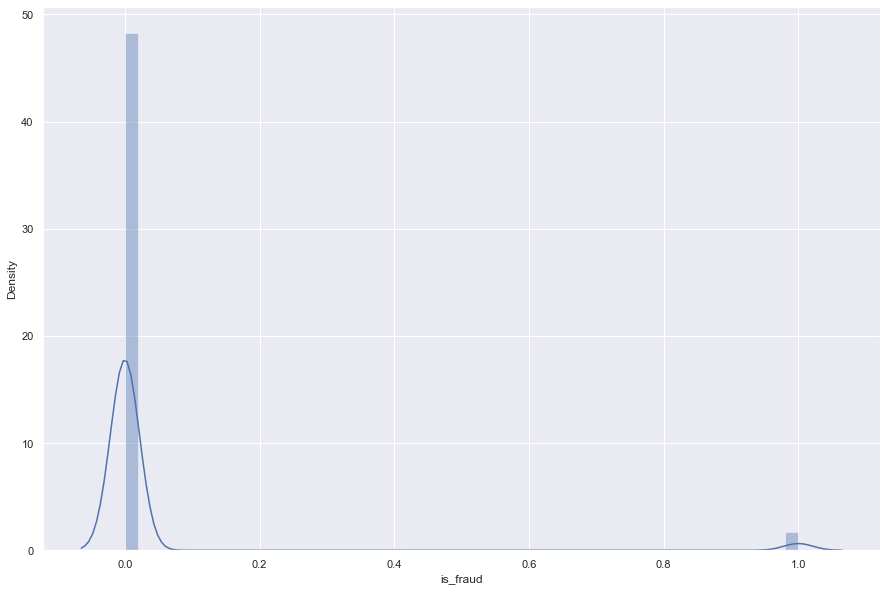

In [432]:
sns.distplot(df4['is_fraud'])

### 4.1.3 Numerical Variables

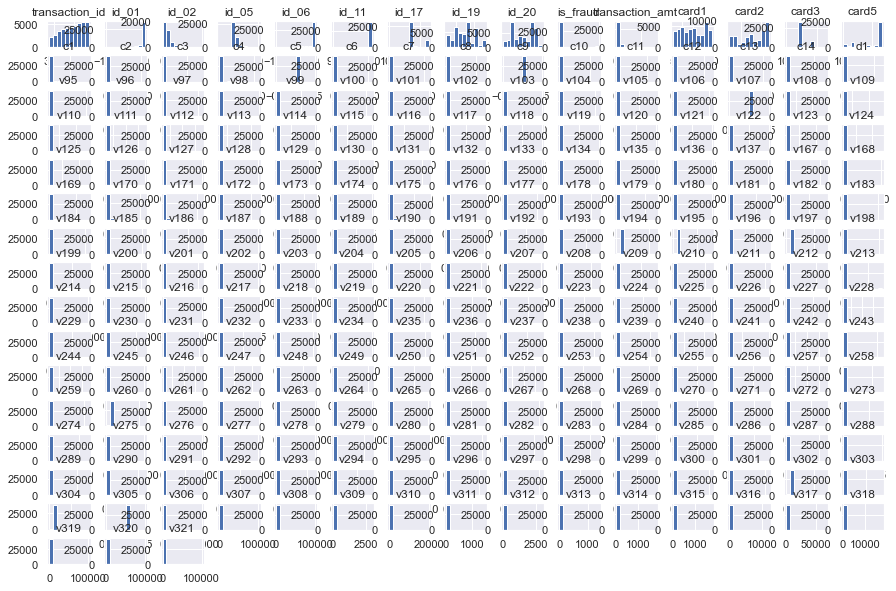

In [433]:
num_attributes.hist();

### 4.1.4 Categorical Variables

In [434]:
for i in df4[cols_cat]:
    print(len(df4[i].unique()))

2
3
2
2
2
82
2
2
2
2
2
4
4
3
59


## 4.1 Analise Bivariada

## **H1.** Deveriam ocorrer mais fraudes em transações de produtos H
**FALSA** Fraudes acontecem mais em produtos H

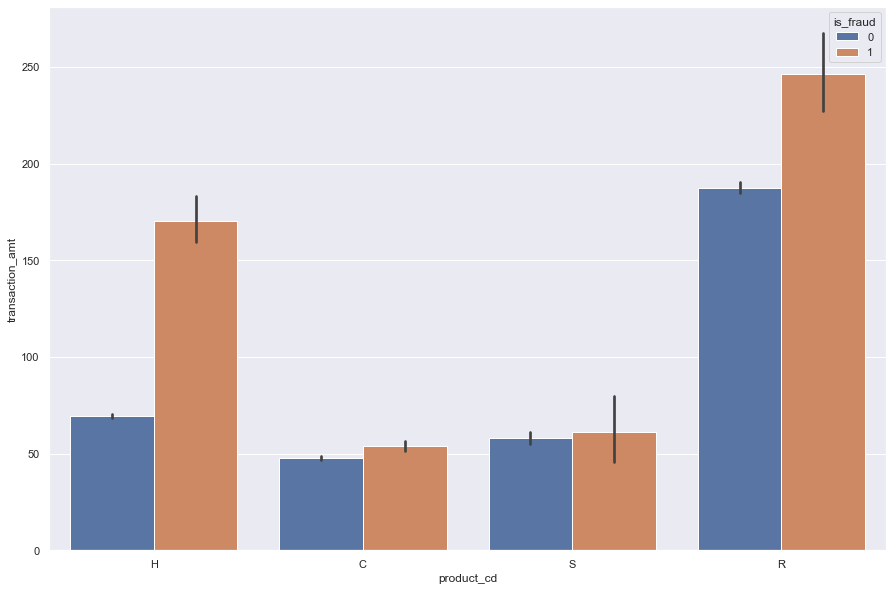

In [278]:
aux1 = df4[['transaction_amt', 'product_cd']].groupby('product_cd').sum().reset_index()
sns.barplot( x=df4['product_cd'], hue=df4['is_fraud'], y=df4['transaction_amt'], data=aux1 );

## H2. Fraudes deveriam acontecer mais em cartão de débito.
**FALSO** Fraudes acontecem mais em cartão de crédito.

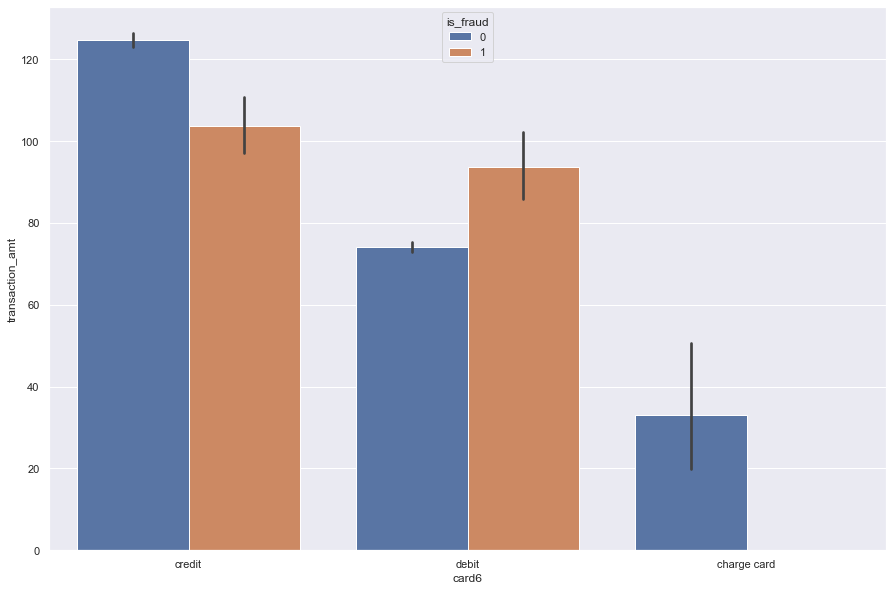

In [282]:
sns.barplot( x=df4['card6'], hue=df4['is_fraud'], y=df4['transaction_amt']);

## H3. Fraudes deveriam acontecer mais em cartão com bandeira Visa.
**FALSO** Fraudes acontecem mais em cartão com bandeira Mastercard.

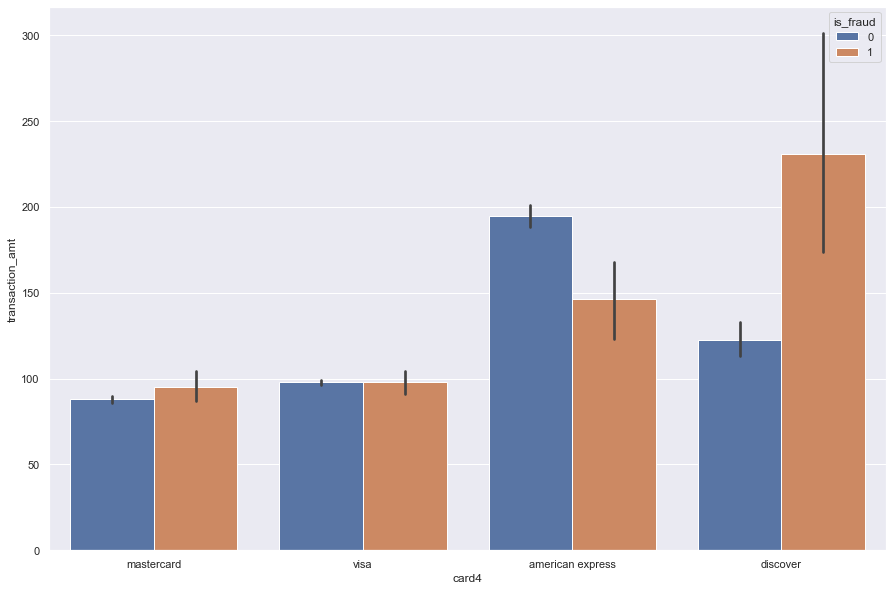

In [284]:
sns.barplot( x=df4['card4'], y=df4['transaction_amt'], hue=df4['is_fraud'] );

## H4. Fraudes devveriam acontecer mais em e-mails com dominio gmail.
**FALSO** Fraudes acontecem mais em dominios @protonmail

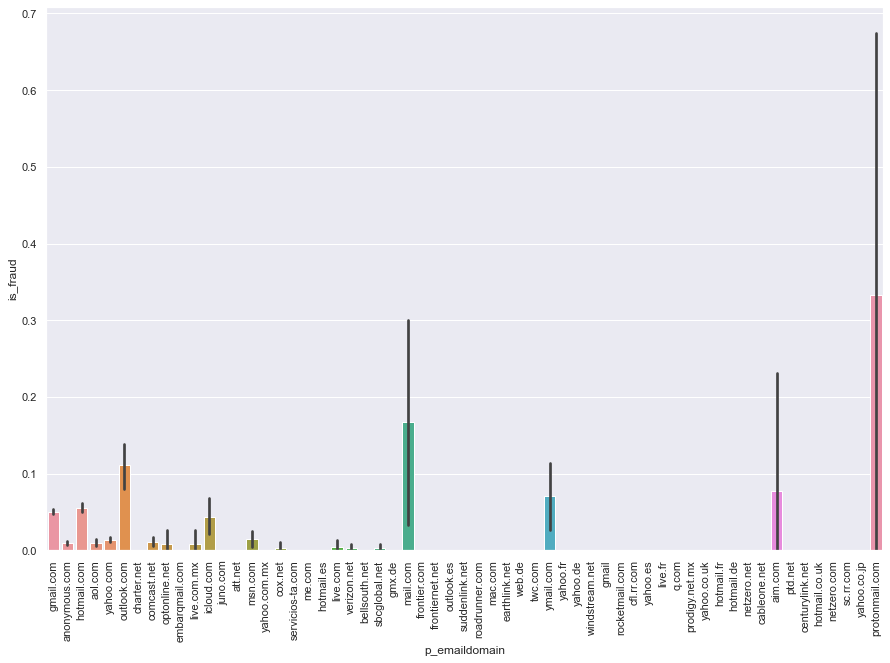

In [288]:
aux2 = df4[['is_fraud', 'p_emaildomain']].groupby('p_emaildomain').sum().reset_index()
sns.barplot( x=df4['p_emaildomain'], y=df4['is_fraud'], data=aux1 );
plt.xticks( rotation=90 );

## H5. Deveriam ocorrer mais fraudes em transações realizadas no periodo matutino
**VERDADEIRA** Transações fraudulentas ocorrem mais no periodo matutino. 

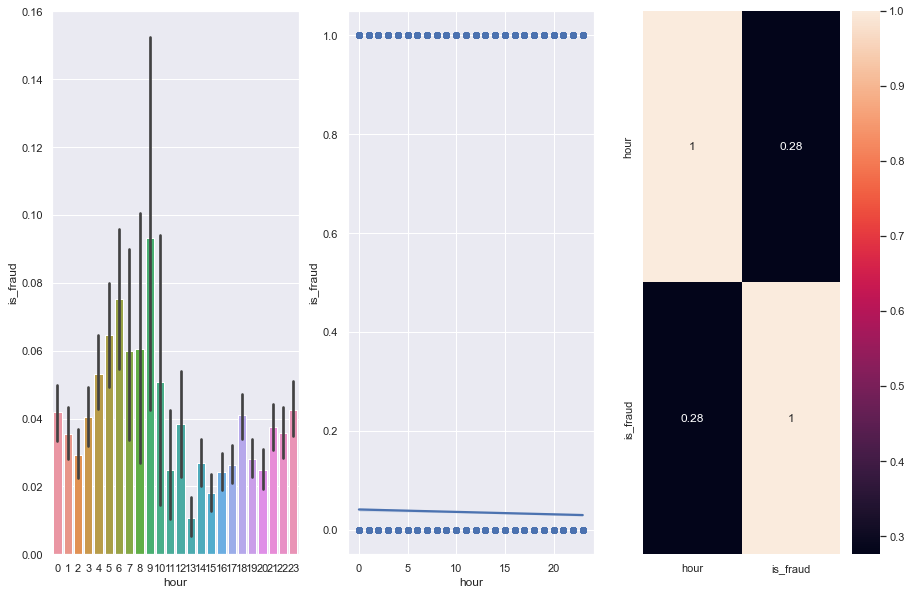

In [271]:
plt.subplot(1, 3, 1)
aux1 = df4[['is_fraud', 'hour']].groupby('hour').sum().reset_index()
sns.barplot(x=df4['hour'], y=df4['is_fraud'], data=aux1);

plt.subplot( 1, 3, 2 )
sns.regplot( x=df4['hour'], y=df4['is_fraud'] );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

## H6. Deveriam ocorrer mais fraudes em transações realizadas durante a semana.
**FALSO** Transações são mais fraudulentas aos finais de semana.

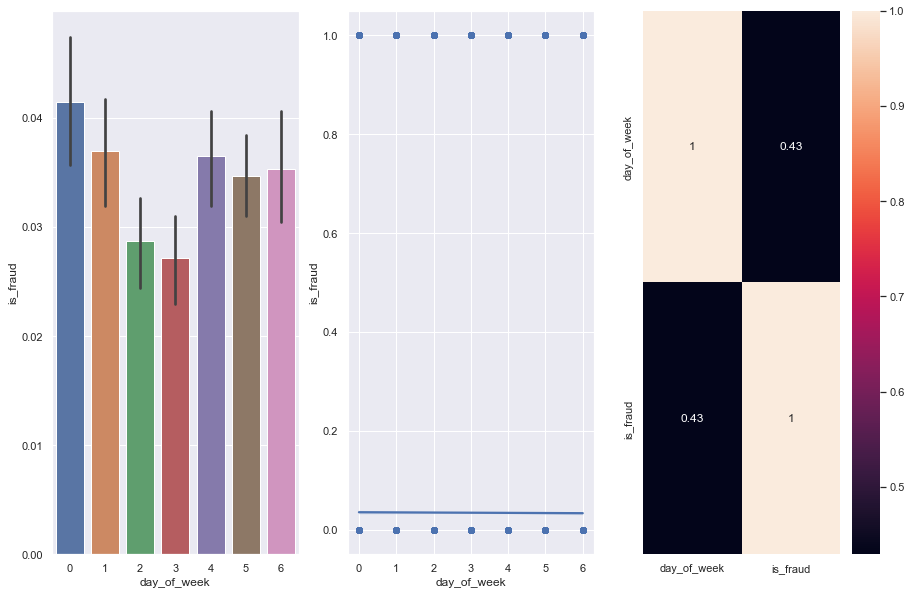

In [265]:
aux1 = df4[['day_of_week', 'is_fraud']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x=df4['day_of_week'], y=df4['is_fraud'], data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x=df4['day_of_week'], y=df4['is_fraud'], data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

## H7. Transações fraudulentas deveriam acontecer em compras de alto valor.
**FALSA** Transações fraudulentas acontecem mais transações de maiores valores.

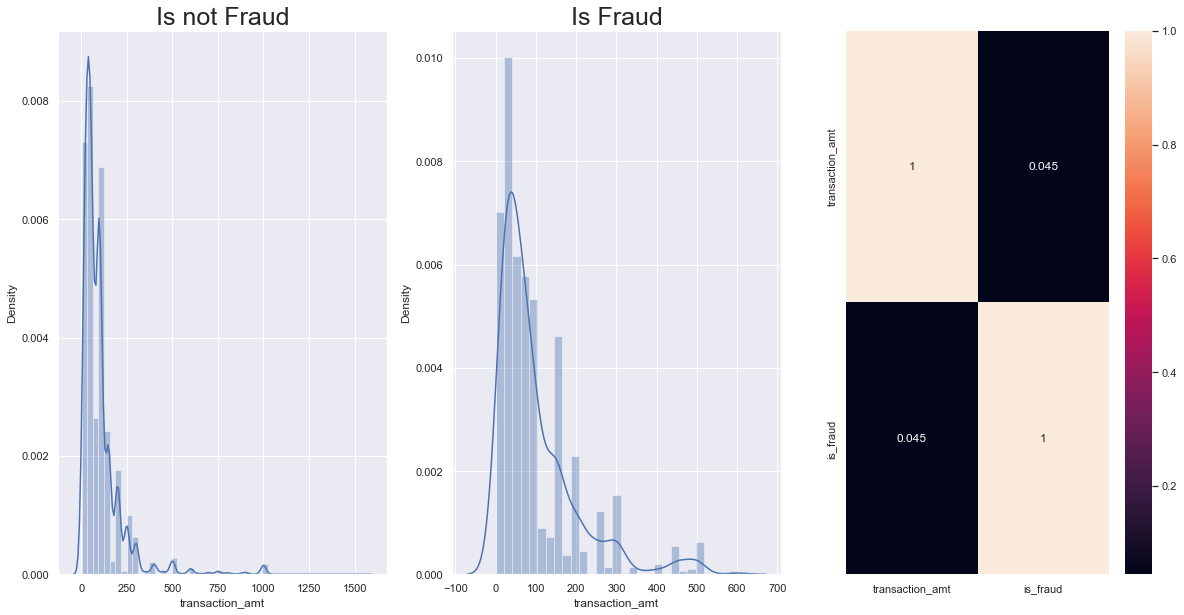

In [449]:
plt.figure(figsize = (20,10))
plt.subplot(1,3,1)
aux = df4[df4['is_fraud'] == 0]
sns.distplot(aux['transaction_amt'])
plt.title("Is not Fraud", fontsize = 25)

plt.subplot(1,3,2)
aux1 = df4[df4['is_fraud'] == 1]
sns.distplot(aux1['transaction_amt'], kde = True)
plt.title("Is Fraud", fontsize = 25)

plt.subplot(1,3,3)
aux2 = df4[['transaction_amt', 'is_fraud']].groupby( 'transaction_amt' ).sum().reset_index()
sns.heatmap( aux2.corr( method='pearson' ), annot=True );

## 4.2 Analise Multivariada

## 4.2.1 Numerical Attributes

## 4.2.1 Categorical Attributes

In [ ]:
df4_ = df4[cols_cat]

rows= []

for var1 in df4_:
  col = []
  for var2 in df4_ :
    cramers =cramers_V(df4_[var1], df4_[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df41 = pd.DataFrame(cramers_results, columns = df4_.columns, index =df4_.columns)

# ploting 
mask = np.zeros_like(df41, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
      ax = sns.heatmap(df41, mask=mask,vmin=0., vmax=1, square=True)

plt.show()

## 4.4 Resumo das Hipoteses

In [451]:
headers = ['Hipoteses', 'Conclusão', 'Relevância']
           
tab =[['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Baixa'],
      ['H3', 'Falsa', 'Baixa'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', 'Verdadeira', 'Média'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Média']]
print( tabulate( tab, headers=headers, showindex="always"))

    Hipoteses    Conclusão    Relevância
--  -----------  -----------  ------------
 0  H1           Falsa        Baixa
 1  H2           Falsa        Baixa
 2  H3           Falsa        Baixa
 3  H4           Falsa        Baixa
 4  H5           Verdadeira   Média
 5  H6           Falsa        Baixa
 6  H7           Falsa        Média


# 5.0 PREPARAÇÃO DOS DADOS

In [ ]:
df5 = df4.copy()

## 5.3 Transformação


## 5.3.1 Encoding

In [ ]:
le= LabelEncoder()
df5[cols_cat] = df5[cols_cat].apply(le.fit_transform)
pickle.dump(le, open('parameters/categorial_features_scaler.pkl', 'wb'))

# 6.0 FEATURE SELECTION

In [ ]:
df6 = df5.copy()

## 6.1 Split dataframe into train and test

In [400]:
cols_selected = ['c1', 'id_02', 'transaction_id', 'c11', 'transaction_amt', 'c13',
       'card1', 'card2', 'c6', 'c14', 'id_19', 'id_20', 'c2', 'id_31',
       'c12', 'c4', 'c8', 'id_05', 'id_01', 'card5', 'p_emaildomain',
       'c10', 'c7', 'id_06', 'product_cd', 'card3', 'id_17', 'card6',
       'card4', 'device_type', 'd1', 'id_15', 'id_11', 'v113', 'id_28',
       'id_16', 'id_37', 'id_29', 'id_38', 'v111', 'v109', 'id_35',
       'id_12', 'v110', 'id_36', 'v101', 'v112', 'v96', 'v103', 'v95',
       'v108', 'v102', 'v97', 'v106', 'v99', 'v115', 'v105', 'v104',
       'v100', 'v114', 'v98', 'c3', 'v107', 'c9', 'c5']

feat_add = ['is_fraud', 'transaction_dt']

cols_selected.extend(feat_add)

df6 = df6[cols_selected]

In [405]:
X = df6.drop(['is_fraud', 'transaction_dt'], axis = 1) 
y = df5['is_fraud']

# split dataset into train, test
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)

## 6.2 Boruta as Feature Selector

In [408]:
#training and test dataset for boruta
#X_train_n = X_train.values
#y_train_n = y_train.values.ravel()
#
#define RandomForestRegressor
#rf = RandomForestClassifier(n_jobs = -1, random_state = 42)
#
#define boruta
#boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n,y_train_n)

In [409]:
#best features from boruta
#cols_selected = boruta.support_.tolist()
#cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()
#cols_selected_boruta

## 6.3 Random Forest as Feature Selector

In [410]:
# feature importances 
#rf = RandomForestClassifier(n_jobs = -1, random_state = 42 ).fit(X_train, y_train)
#feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
# show 15 most importance features
#feat_importances.head(16).sort_values().plot(kind='barh')
#feat_importances[:65].sort_values(ascending=False)

# 7.0 MACHINE LEARNING MODELLING

##  7.1 Baseline Tree Classifier

In [411]:
# model
baseline = DecisionTreeClassifier(random_state = 42).fit(X_train, y_train)

yhat_baseline = baseline.predict( X_test)

# perfomance
baseline_result = ml_error('Decision Tree Classifier', y_test, yhat_baseline)
baseline_result

,Model Name,Accuracy,Precision,F1 Score,Recall Score
0,Decision Tree Classifier,0.972093,0.562633,0.604333,0.652709


##  7.1.2 Baseline Tree Classifier - Cross Validation

In [412]:
baseline_cv = cross_validation( 'Decision Tree Classifier', baseline, cv=5)
baseline_cv

,Model Name,Accuracy,Precision,F1-Measure,Recall,AUC-ROC
0,Decision Tree Classifier,0.9673 +- 0.0025,0.5252 +- 0.0306,0.5519 +- 0.0381,0.582 +- 0.0494,0.7816 +- 0.0249


## 7.2 Random Forest Model

In [413]:
# model
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

yhat_rf = rf.predict( X_test)

# perfomance
rf_result = ml_error('Random Forest Classifier', y_test, yhat_rf)
rf_result

,Model Name,Accuracy,Precision,F1 Score,Recall Score
0,Random Forest Classifier,0.984719,0.928571,0.711246,0.576355


## 7.2.1 Random Forest Model - Cross Validation

In [414]:
rf_cv = cross_validation( 'Random Forest Classifier', rf, cv=5)
rf_cv

,Model Name,Accuracy,Precision,F1-Measure,Recall,AUC-ROC
0,Random Forest Classifier,0.9822 +- 0.0013,0.9521 +- 0.0252,0.6668 +- 0.0282,0.5135 +- 0.0292,0.937 +- 0.0151


## 7.3 XGB Classifier

In [415]:
# model
model_xgb = xgb.XGBClassifier(random_state=42, n_jobs=-1).fit(X_train, y_train)

# prediction 
yhat_xgb = model_xgb.predict( X_test )

# perfomance
xgb_result = ml_error( 'XGBoost Classifier', y_test, yhat_xgb)
xgb_result

[16:29:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model Name,Accuracy,Precision,F1 Score,Recall Score
0,XGBoost Classifier,0.986891,0.914676,0.76681,0.660099


## 7.3.1 XGB Classifier - Cross Validation

In [416]:
xgb_cv = cross_validation( 'XGBoost Classifier', model_xgb, cv=5)
xgb_cv

[16:29:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:29:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:29:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:29:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,Model Name,Accuracy,Precision,F1-Measure,Recall,AUC-ROC
0,XGBoost Classifier,0.9846 +- 0.0017,0.9211 +- 0.0135,0.7325 +- 0.0348,0.6088 +- 0.0432,0.953 +- 0.0077


##  7.4 LGBM Classifier

In [417]:
# model
lgbm = LGBMClassifier(random_state=42, n_jobs=-1).fit(X_train, y_train)

# prediction 
yhat_lgbm = lgbm.predict( X_test )

# perfomance
lgbm_result = ml_error( 'LGBM Classifier', y_test, yhat_lgbm)
lgbm_result

,Model Name,Accuracy,Precision,F1 Score,Recall Score
0,LGBM Classifier,0.985845,0.885906,0.75,0.650246


##  7.4.1 LGBM - Cross Validation

In [418]:
lgbm_cv = cross_validation( 'LGBM Classifier', lgbm, cv=5)
lgbm_cv

,Model Name,Accuracy,Precision,F1-Measure,Recall,AUC-ROC
0,LGBM Classifier,0.9836 +- 0.0015,0.9165 +- 0.0079,0.7089 +- 0.0325,0.579 +- 0.0426,0.9548 +- 0.0109


## 7.5 Compare Model's Perfomance

## 7.5.1. Single Performance

In [419]:
modelling_result = pd.concat( [baseline_result, rf_result, xgb_result, lgbm_result] )
modelling_result.sort_values( 'F1 Score', ascending=False)

,Model Name,Accuracy,Precision,F1 Score,Recall Score
0,XGBoost Classifier,0.986891,0.914676,0.766810,0.660099
0,LGBM Classifier,0.985845,0.885906,0.750000,0.650246
0,Random Forest Classifier,0.984719,0.928571,0.711246,0.576355
0,Decision Tree Classifier,0.972093,0.562633,0.604333,0.652709


##   7.5.2. Real Performance - Cross Validation

In [420]:
modelling_result = pd.concat( [baseline_cv, rf_cv, xgb_cv, lgbm_cv] )
modelling_result.sort_values( 'AUC-ROC', ascending=False)

,Model Name,Accuracy,Precision,F1-Measure,Recall,AUC-ROC
0,LGBM Classifier,0.9836 +- 0.0015,0.9165 +- 0.0079,0.7089 +- 0.0325,0.579 +- 0.0426,0.9548 +- 0.0109
0,XGBoost Classifier,0.9846 +- 0.0017,0.9211 +- 0.0135,0.7325 +- 0.0348,0.6088 +- 0.0432,0.953 +- 0.0077
0,Random Forest Classifier,0.9822 +- 0.0013,0.9521 +- 0.0252,0.6668 +- 0.0282,0.5135 +- 0.0292,0.937 +- 0.0151
0,Decision Tree Classifier,0.9673 +- 0.0025,0.5252 +- 0.0306,0.5519 +- 0.0381,0.582 +- 0.0494,0.7816 +- 0.0249


# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search 

In [421]:
#define model
#model_lgbm = LGBMClassifier(n_jobs = -1, random_state = 42)

#parameters
#parameters = {'max_depth': np.arange(2, 12, 2), 
#         'num_leaves': 2 ** np.arange(2, 10, 2),
#         'min_data_in_leaf': np.arange(100, 1050, 50), 
#         'learning_rate': np.linspace(0.001, 0.6, 15),
#         'colsample_bytree': np.linspace(0.1, 1, 5),
#         'subsample': np.linspace(0.25, 1, 15),
#         'n_estimators': np.arange(10, 105, 15)}

#define RandomSearchCV
#lgbm_random_cv = RandomizedSearchCV(estimator=model_lgbm, param_distributions=parameters,
#                                scoring='accuracy', n_iter=100, cv=5, verbose=2,
#                                random_state=42, n_jobs=-1)

#fit RandomSearchCV
#lgbm_random_cv.fit(X_train, np.ravel(y_train))

In [422]:
#get the best parameters to our model
lgbm_random_cv.best_estimator_

LGBMClassifier(learning_rate=0.17214285714285713, max_depth=10,
               min_data_in_leaf=200, n_estimators=70, num_leaves=64,
               random_state=42)

## 8.2 Final Model

In [424]:
# LGBMClassifier with GPU

lgbm_tuned = LGBMClassifier(
          max_bin = 63,
          num_leaves = 255,
          num_iterations = 500,
          learning_rate = 0.01,
          tree_learner = 'serial',
          is_dfing_metric = False,
          min_data_in_leaf = 1,
          min_sum_hessian_in_leaf = 100,
          sparse_threshold=1.0,
          # device = 'gpu',
          num_thread = -1,
          save_binary= True,
          seed= 42,
          feature_fraction_seed = 42,
          bagging_seed = 42,
          drop_seed = 42,
          data_random_seed = 42,
          objective = 'binary',
          boosting_type = 'gbdt',
          verbose = 1,
          metric = 'auc',
          scale_pos_weight = 32,
          boost_from_average = False).fit(X_train, y_train)

yhat_lgbm_tuned = lgbm_tuned.predict( X_test )

# perfomance
lgbm_tuned_result = ml_error( 'LGBM Classifier', y_test, yhat_lgbm_tuned)
lgbm_tuned_result

[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: is_dfing_metric
[LightGBM] [Warning] num_threads is set with n_jobs=-1, num_thread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=100, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=100
[LightGBM] [Warning] Unknown parameter: sparse_threshold
[LightGBM] [Warning] Unknown parameter: is_dfing_metric
[LightGBM] [Warning] num_threads is set with n_jobs=-1, num_thread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=100, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=100
[LightGBM] [Info] Nu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,Model Name,Accuracy,Precision,F1 Score,Recall Score
0,LGBM Classifier,0.938556,0.334566,0.486559,0.891626


# 9.0 INTERPRETAÇÃO E TRADUÇÃO DO ERRO

In [425]:
df9 = X_test

In [426]:
df9['is_fraud'] = y_test
df9['predictions'] = yhat_lgbm_tuned

##  9.1. Business Performance

In [427]:
df = df9.copy()
_1 = fraud_loss_saved(df, 'Decision Tree Classifier', baseline_result, yhat_baseline)
_2 = fraud_loss_saved(df, 'Random Forest Tree', rf_result, yhat_rf)
_3 = fraud_loss_saved(df, 'XGBoost Classifier', xgb_result, yhat_xgb)
_4 = fraud_loss_saved(df, 'LGBM (W/ Hyperparameters Adjusted)', lgbm_tuned_result, yhat_lgbm_tuned)


total_perfomance = pd.concat([_1, _2,_3,_4])
total_perfomance.sort_values( ['AUROC Score'], ascending= False, inplace = True)
total_perfomance

,Model Name,Total Fraud Amount,Total Fraud Amount Detected,Fraud Loss Saved (%),Detection Rate (%),AUROC Score,F1 Score
0,LGBM (W/ Hyperparameters Adjusted),39167.654,34643.091,88.45,89.162562,0.915883,0.486559
0,XGBoost Classifier,39167.654,27549.831,70.34,66.009852,0.829010,0.766810
0,Decision Tree Classifier,39167.654,25966.340,66.3,65.270936,0.817791,0.604333
0,Random Forest Tree,39167.654,23091.510,58.96,57.635468,0.787429,0.711246


## 9.2 Machine Learning Perfomance  

In [428]:
#machine leraning model
baseline_probs = baseline.predict_proba(X_test)
lgbm_probs = lgbm.predict_proba(X_test)
xgb_probs = model_xgb.predict_proba(X_test)
rf_probs = rf.predict_proba(X_test)


# keep probabilities for the positive outcome only
ns_probs = [0 for _ in range(len(y_test))]
baseline_probs = baseline_probs[:, 1]
lgbm_probs = lgbm_probs[:,1]
xgb_probs = xgb_probs[:,1]
rf_probs = rf_probs[:,1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
baseline_auc = roc_auc_score(y_test, baseline_probs)
lgbm_auc = roc_auc_score(y_test, lgbm_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Baseline: ROC AUC=%.3f' % (baseline_auc))
print('RandomForestClassifier: ROC AUC=%.3f' % (rf_auc))
print('XGBoostClassifier: ROC AUC=%.3f' % (xgb_auc))
print('LGBM: ROC AUC=%.3f' % (lgbm_auc))

plt.figure(figsize(15, 10))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(baseline_fpr, baseline_tpr, marker='.', label='Baseline Tree Classifier')
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LGBM')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoostClassifier')
plt.plot(rf_fpr, rf_tpr, marker='.', label='RandomForestClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

ValueError: X has 67 features, but DecisionTreeClassifier is expecting 65 features as input.

<Figure size 1440x360 with 0 Axes>

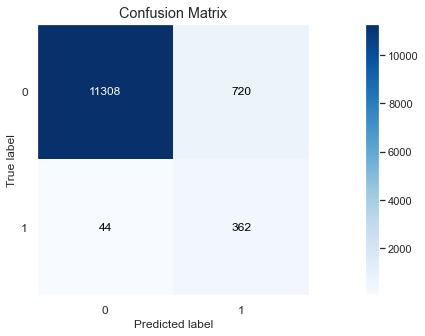

In [429]:
plt.figure(figsize(20, 5))
mt.plot_confusion_matrix(y_test, yhat_lgbm_tuned, normalize = False);

<Figure size 1080x720 with 0 Axes>

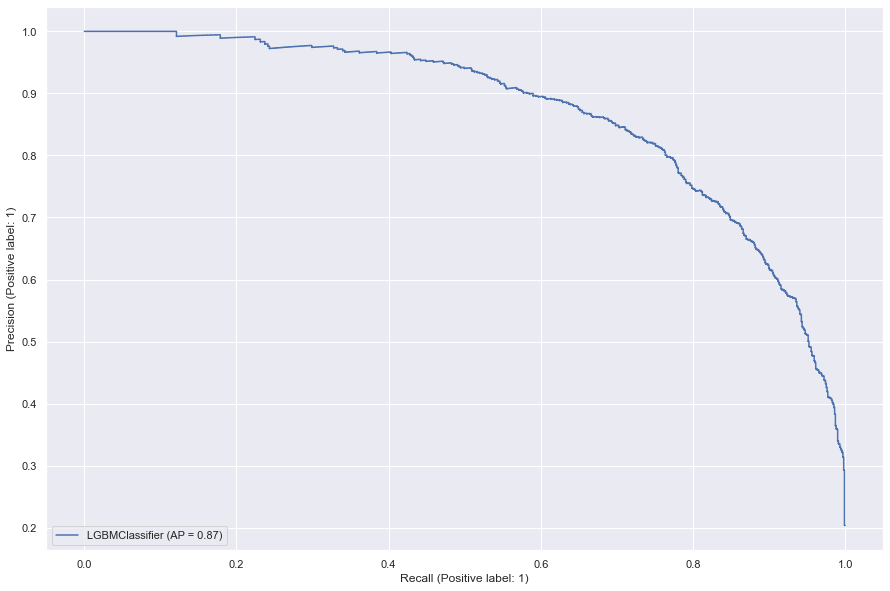

In [430]:
plt.figure(figsize(15,10))
plot_precision_recall_curve(lgbm_tuned, X_train, y_train);

# 10.0 FUTURE WORKS

## 10.1 Deploy Model To Production

In [ ]:
# Save Trained Model
filename = 'model\lgbmmodel.pkl'
pickle.dump(lgbm_tuned_result, open(filename, 'wb'))